<a href="https://colab.research.google.com/github/FacuML/NLP/blob/main/002_Parte/012/004_ner_gemini_gradio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocimiento de Entidades Nombradas
## Ejercicio Práctico - Procesamiento de Lenguaje Natural

**Objetivos de Aprendizaje:**
1. Implementar NER usando modelos pre-entrenados en español
2. Crear interfaces interactivas con Gradio
3. Comparar enfoques: Transformers vs API Gemini
4. Desarrollar prototipos rápidos para aplicaciones de PLN

---
**Entorno recomendado:** Google Colab o Amazon SageMaker Studio

**Tiempo estimado:** 60-90 minutos

## Instalación de Dependencias

In [ ]:
# Instalación de librerías necesarias
%%capture
!pip install -q transformers torch gradio google-genai

In [ ]:
# Verificar instalación
import sys
print(f"Python: {sys.version}")
print("Todas las dependencias instaladas correctamente")

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Todas las dependencias instaladas correctamente


## Configuración de APIs

### Para Google Colab:
1. Andá a la barra lateral izquierda y hacé clic en 🔑 (Secrets)
2. Agrega una nueva clave: `GOOGLE_API_KEY`
3. Pega tu API key de Google AI Studio

### Para SageMaker Studio:
1. Configura las variables de entorno en tu instancia
2. O usa el método de input manual más abajo

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

# Configuración de API Key para Gemini
try:
    # Método 1: Google Colab Secrets
    from google.colab import userdata
    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
    print("API Key cargada desde Google Colab Secrets")
except:
    # Método 2: Variables de entorno (SageMaker)
    GOOGLE_API_KEY = os.environ.get('GOOGLE_API_KEY')
    if GOOGLE_API_KEY:
        print("API Key cargada desde variables de entorno")
    else:
        print("No se encontró GOOGLE_API_KEY")
        print("Podes continuar solo con la parte de Transformers")

API Key cargada desde Google Colab Secrets


---
# PARTE 1: NER con Transformers de Hugging Face

Utilizaremos un modelo especializado en español que puede identificar:
- **PER**: Personas
- **LOC**: Lugares
- **ORG**: Organizaciones  
- **MISC**: Misceláneo

In [ ]:
from transformers import pipeline
import torch

# Verificar disponibilidad de GPU
device = 0 if torch.cuda.is_available() else -1
print(f"🖥️  Dispositivo: {'GPU' if device == 0 else 'CPU'}")

# Cargar modelo de NER en español
print("📥 Cargando modelo de NER para español...")
MODEL_NAME = "mrm8488/bert-spanish-cased-finetuned-ner"

try:
    ner_pipeline = pipeline(
        "ner",
        model=MODEL_NAME,
        aggregation_strategy="simple",
        device=device
    )
    print(f"Modelo {MODEL_NAME} cargado exitosamente")
except Exception as e:
    print(f"❌ Error al cargar modelo: {e}")
    ner_pipeline = None

🖥️  Dispositivo: GPU
📥 Cargando modelo de NER para español...


config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of the model checkpoint at mrm8488/bert-spanish-cased-finetuned-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


Modelo mrm8488/bert-spanish-cased-finetuned-ner cargado exitosamente


In [ ]:
# Texto de ejemplo con contexto argentino
texto_ejemplo = """
Hola, soy María González y trabajo en la Universidad de Buenos Aires.
Vivo en el barrio de San Telmo y mi empresa favorita es MercadoLibre.
La semana pasada visité el Obelisco con mi amigo Carlos Pérez,
quien trabaja en Google Argentina. Nos encontramos en la estación
Constitución del subte y fuimos a comer un asado en La Boca.
"""

In [ ]:
def analizar_entidades_transformers(texto):
    """Procesa texto y extrae entidades usando Transformers"""
    if not ner_pipeline:
        return []

    entidades = ner_pipeline(texto)

    # Formatear resultados
    resultados = []
    for ent in entidades:
        resultados.append({
            'texto': ent['word'],
            'etiqueta': ent['entity_group'],
            'confianza': round(ent['score'], 3),
            'posicion': (ent['start'], ent['end'])
        })

    return resultados

In [ ]:
# Probar el modelo
print("🔍 Analizando texto de ejemplo...")
print(f"📝 Texto: {texto_ejemplo.strip()}")
print("\n📊 Entidades encontradas:")

entidades_encontradas = analizar_entidades_transformers(texto_ejemplo)
for ent in entidades_encontradas:
    print(f"  • {ent['texto']} → {ent['etiqueta']} (confianza: {ent['confianza']})")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


🔍 Analizando texto de ejemplo...
📝 Texto: Hola, soy María González y trabajo en la Universidad de Buenos Aires.
Vivo en el barrio de San Telmo y mi empresa favorita es MercadoLibre.
La semana pasada visité el Obelisco con mi amigo Carlos Pérez,
quien trabaja en Google Argentina. Nos encontramos en la estación
Constitución del subte y fuimos a comer un asado en La Boca.

📊 Entidades encontradas:
  • María González → PER (confianza: 0.9990000128746033)
  • Universidad de Buenos Aires → ORG (confianza: 0.9990000128746033)
  • San Telmo → LOC (confianza: 0.9980000257492065)
  • MercadoLibre → ORG (confianza: 0.996999979019165)
  • Obelisco → LOC (confianza: 0.9959999918937683)
  • Carlos Pérez → PER (confianza: 1.0)
  • Google Argentina → ORG (confianza: 0.9860000014305115)
  • Constitución → LOC (confianza: 0.9950000047683716)
  • La Boca → LOC (confianza: 1.0)


---
# PARTE 2: NER con API de Gemini

Utilizaremos la API de Gemini para un análisis más detallado y contextual.

In [ ]:
# Configurar cliente Gemini
cliente_gemini = None

if GOOGLE_API_KEY:
    try:
        from google import genai
        cliente_gemini = genai.Client(api_key=GOOGLE_API_KEY)
        print("Cliente Gemini configurado correctamente")
    except Exception as e:
        print(f"Error al configurar Gemini: {e}")
else:
    print("API Key de Gemini no disponible")
    print("Podes obtener una gratis en: https://ai.google.dev/")

Cliente Gemini configurado correctamente


In [ ]:
def analizar_entidades_gemini(texto):
    """Analiza entidades usando Gemini API"""
    if not cliente_gemini:
        return "❌ Cliente Gemini no disponible"

    prompt = f"""
    Extraé todas las entidades nombradas del siguiente texto en español argentino y clasificálas:

    CATEGORÍAS:
    - PERSONA: Nombres de personas
    - LUGAR: Ciudades, países, barrios, direcciones, lugares específicos
    - ORGANIZACIÓN: Empresas, universidades, instituciones
    - MISCELÁNEO: Otros nombres propios (productos, eventos, marcas)

    FORMATO DE RESPUESTA:
    [ENTIDAD] → [CATEGORÍA] → [BREVE EXPLICACIÓN]

    TEXTO A ANALIZAR:
    {texto}
    """

    try:
        respuesta = cliente_gemini.models.generate_content(
            model="gemini-2.0-flash",
            contents=[prompt]
        )
        return respuesta.text
    except Exception as e:
        return f"❌ Error: {e}"

# Probar Gemini si está disponible
if cliente_gemini:
    print("🔍 Analizando con Gemini...")
    resultado_gemini = analizar_entidades_gemini(texto_ejemplo)
    print("\nAnálisis de Gemini:")
    print(resultado_gemini)
else:
    print("⏭️  Saltando análisis con Gemini (API Key no disponible)")

🔍 Analizando con Gemini...

Análisis de Gemini:
Aquí están las entidades nombradas extraídas del texto, clasificadas según las categorías proporcionadas:

*   María González → PERSONA → Nombre de la persona que habla.
*   Universidad de Buenos Aires → ORGANIZACIÓN → Nombre de la universidad.
*   San Telmo → LUGAR → Nombre del barrio.
*   MercadoLibre → ORGANIZACIÓN → Nombre de la empresa.
*   Obelisco → LUGAR → Monumento famoso en Buenos Aires.
*   Carlos Pérez → PERSONA → Nombre del amigo.
*   Google Argentina → ORGANIZACIÓN → Subdivisión de Google en Argentina.
*   Constitución → LUGAR → Nombre de la estación de subte.
*   La Boca → LUGAR → Nombre del barrio.



---
# PARTE 3: Interfaces Interactivas con Gradio

Crearemos interfaces web interactivas para probar nuestros modelos.

In [ ]:
import gradio as gr

def interfaz_ner_transformers(texto):
    """Interfaz para el modelo de Transformers"""
    if not texto.strip():
        return {"text": "Ingresa un texto para analizar", "entities": []}

    if not ner_pipeline:
        return {"text": "Modelo no disponible", "entities": []}

    # Procesar con Transformers
    entidades = ner_pipeline(texto)

    # Formatear para Gradio HighlightedText
    entidades_gradio = []
    for ent in entidades:
        entidades_gradio.append({
            "entity": ent["entity_group"],
            "word": ent["word"],
            "start": ent["start"],
            "end": ent["end"],
            "score": ent["score"]
        })

    return {"text": texto, "entities": entidades_gradio}

# Ejemplos para la interfaz
ejemplos_arg = [
    "Me llamo Juan Pérez y trabajo en el Banco Nación en Buenos Aires.",
    "Cristina Kirchner fue presidenta de Argentina y vive en Santa Cruz.",
    "River Plate jugará contra Boca Juniors en el estadio Monumental.",
    "Lionel Messi nació en Rosario y jugó en el Barcelona.",
    "La Universidad de La Plata es muy prestigiosa en Argentina."
]

# Crear interfaz
demo_transformers = gr.Interface(
    fn=interfaz_ner_transformers,
    inputs=[
        gr.Textbox(
            label="📝 Texto a analizar",
            placeholder="Escribe aquí tu texto en español...",
            lines=4
        )
    ],
    outputs=[
        gr.HighlightedText(
            label="🎯 Entidades Identificadas",
            show_legend=True
        )
    ],
    title="NER con Transformers - Español (de argentina)",
    description="""
    **Modelo:** `mrm8488/bert-spanish-cased-finetuned-ner`

    Identifica entidades nombradas en textos en español:
    - 🧑 **PER**: Personas
    - 🌍 **LOC**: Lugares
    - 🏢 **ORG**: Organizaciones
    - 📦 **MISC**: Misceláneo
    """,
    examples=ejemplos_arg,
    allow_flagging="never",
    theme=gr.themes.Soft()
)

print("✅ Interfaz de Transformers creada")

✅ Interfaz de Transformers creada


In [ ]:
# Interfaz para Gemini (solo si está disponible)
if cliente_gemini:
    def interfaz_ner_gemini(texto):
        """Interfaz para Gemini API"""
        if not texto.strip():
            return "Ingresa un texto para analizar"
        return analizar_entidades_gemini(texto)

    demo_gemini = gr.Interface(
        fn=interfaz_ner_gemini,
        inputs=[
            gr.Textbox(
                label="📝 Texto a analizar",
                placeholder="Escribe aquí tu texto en español...",
                lines=4
            )
        ],
        outputs=[
            gr.Textbox(
                label="🧠 Análisis de Gemini",
                lines=10
            )
        ],
        title="NER con Gemini - Análisis Detallado",
        description="""
        **Modelo:** Google Gemini 2.0 Flash

        Análisis avanzado de entidades nombradas con explicaciones contextuales
        optimizado para español argentino.
        """,
        examples=ejemplos_arg,
        allow_flagging="never",
        theme=gr.themes.Soft()
    )
    print("✅ Interfaz de Gemini creada")
else:
    print("⏭️  Interfaz de Gemini no creada (API Key no disponible)")

✅ Interfaz de Gemini creada


In [ ]:
# Interfaz comparativa (solo si ambos están disponibles)
if ner_pipeline and cliente_gemini:
    def comparar_modelos(texto):
        """Compara resultados de ambos modelos"""
        if not texto.strip():
            return "Ingresa texto para comparar", "Ingresa texto para comparar"

        # Resultado Transformers
        entidades_tf = analizar_entidades_transformers(texto)
        resultado_tf = "TRANSFORMERS:\n\n"
        for ent in entidades_tf:
            resultado_tf += f"• {ent['texto']} → {ent['etiqueta']} (confianza: {ent['confianza']})\n"

        # Resultado Gemini
        resultado_gemini = "GEMINI:\n\n" + analizar_entidades_gemini(texto)

        return resultado_tf, resultado_gemini

    demo_comparativo = gr.Interface(
        fn=comparar_modelos,
        inputs=[
            gr.Textbox(
                label="📝 Texto a comparar",
                placeholder="Ingresa texto para ver la comparación...",
                lines=3
            )
        ],
        outputs=[
            gr.Textbox(label="Transformers", lines=8),
            gr.Textbox(label="Gemini", lines=8)
        ],
        title="⚔️ Comparación: Transformers vs Gemini",
        description="Compara los resultados de ambos enfoques lado a lado.",
        examples=[
            "Diego Maradona jugó en Boca Juniors y en el Napoli de Italia.",
            "El gobierno argentino anunció medidas desde Casa Rosada."
        ],
        allow_flagging="never"
    )
    print("✅ Interfaz comparativa creada")
else:
    print("⏭️  Interfaz comparativa no creada (requiere ambos modelos)")

✅ Interfaz comparativa creada


## 🚀 Lanzar Interfaces

Ejecuta las celdas siguientes para lanzar las interfaces interactivas:

In [ ]:
# Lanzar interfaz de Transformers
if ner_pipeline:
    print("🚀 Lanzando interfaz de Transformers...")
    demo_transformers.launch(share=True, height=600)
else:
    print("❌ No se puede lanzar: modelo de Transformers no disponible")

🚀 Lanzando interfaz de Transformers...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7af301786714a5b090.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Lanzar interfaz de Gemini
if cliente_gemini:
    print("🚀 Lanzando interfaz de Gemini...")
    demo_gemini.launch(share=True, height=600)
else:
    print("❌ No se puede lanzar: API de Gemini no disponible")

🚀 Lanzando interfaz de Gemini...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c0229f93661f6aa40a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Lanzar interfaz comparativa
if ner_pipeline and cliente_gemini:
    print("🚀 Lanzando interfaz comparativa...")
    demo_comparativo.launch(share=True, height=600)
else:
    print("❌ No se puede lanzar: requiere ambos modelos disponibles")

🚀 Lanzando interfaz comparativa...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://41391a9f4ca2b72dee.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


---
# 🎓 EJERCICIOS

## 📝 Ejercicio 1: Personalización (BÁSICO)
1. Modifica los ejemplos para incluir más contexto argentino específico
2. Agrega 3 ejemplos nuevos con nombres de barrios porteños
3. Probá con texto de diferentes regiones de Argentina

## 🔧 Ejercicio 2: Análisis Comparativo (INTERMEDIO)
1. Crea una función que cuente cuántas entidades encuentra cada modelo
2. Implementa un sistema de métricas de tiempo de procesamiento
3. Analiza en qué casos cada modelo funciona mejor

## 🚀 Ejercicio 3: Extensiones Avanzadas (AVANZADO)
1. Implementa procesamiento en lote de múltiples textos
2. Crea una función de exportación de resultados a CSV
3. Desarrolla un sistema de filtrado por tipo de entidad

## 💡 Proyecto Integrador
Elegí una de estas aplicaciones y desarróllala:
- **Analizador de noticias argentinas**: Extrae personas y lugares de artículos
- **Procesador de CVs**: Identifica nombres, empresas y universidades
- **Análisis de redes sociales**: Detecta menciones de políticos y lugares

## 🤔 Preguntas de Reflexión
1. ¿Cuáles son las ventajas y desventajas de cada enfoque?
2. ¿En qué casos usarías un modelo local vs una API?
3. ¿Cómo evaluarías la precisión de los resultados?
4. ¿Qué consideraciones éticas debemos tener en cuenta?
5. ¿Cómo escalarías esta solución para procesar miles de documentos?

In [ ]:
# 📝 ESPACIO PARA TUS EJERCICIOS
# Usa esta celda para experimentar y desarrollar tus soluciones

# Ejemplo: Función para contar entidades por tipo
def contar_entidades_por_tipo(texto):
    """Cuenta entidades por categoría usando Transformers"""
    if not ner_pipeline:
        return {}

    entidades = ner_pipeline(texto)
    conteo = {}

    for ent in entidades:
        tipo = ent['entity_group']
        if tipo in conteo:
            conteo[tipo] += 1
        else:
            conteo[tipo] = 1

    return conteo

# Probar la función
texto_prueba = "Juan Pérez trabaja en Google Argentina en Buenos Aires con María López."
print("📊 Conteo de entidades:")
print(contar_entidades_por_tipo(texto_prueba))

# TODO: Agrega aquí tus propias funciones y experimentos

#Ejercisio 2:



📊 Conteo de entidades:
{'PER': 2, 'ORG': 1, 'LOC': 1}


---
# 🎯 Conclusión

¡Felicitaciones! Completaste el ejercicio de Reconocimiento de Entidades Nombradas.

## 📚 Lo que aprendiste:
- ✅ Implementar NER con modelos pre-entrenados
- ✅ Usar APIs de IA generativa para tareas de PLN
- ✅ Crear interfaces interactivas con Gradio
- ✅ Comparar diferentes enfoques de NER

## 🔄 Próximos pasos:
1. Experimentá con otros modelos de Hugging Face
2. Probá con textos de diferentes dominios
3. Implementa tu proyecto integrador
4. Compartí tus resultados con la clase

## 📖 Recursos adicionales:
- [Hugging Face Models](https://huggingface.co/models?pipeline_tag=token-classification&language=es)
- [Gradio Documentation](https://gradio.app/docs/)
- [Google AI Studio](https://ai.google.dev/)

---
**¡Éxito en tu trabajo integrador!** 🎓🚀

In [ ]:
!pip install requests


In [ ]:
import requests
import pandas as pd

# Reemplaza "TU_BEARER_TOKEN_AQUI" con tu Bearer Token real de la API de Twitter
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAADVq2gEAAAAAn93BKDtp1aBw8krX0ssQ%2FzFYQ88%3Ds86paPFSBR9Dwj28NsF09Z9SpFOMtQQoJ5Fz7SZw9tQldAQN97"

headers = {
    "Authorization": f"Bearer {BEARER_TOKEN}"
}

query = "Milei OR Massa OR Cristina OR Bullrich OR Larreta lang:es -is:retweet"
url = "https://api.twitter.com/2/tweets/search/recent"

params = {
    "query": query,
    "max_results": 50,
    "tweet.fields": "created_at,lang,text"
}

response = requests.get(url, headers=headers, params=params)

# Check if the request was successful
if response.status_code == 200:
    tweets_data = response.json().get("data", [])  # Use .get() to avoid KeyError if 'data' is missing
    if tweets_data:
        df = pd.DataFrame(tweets_data)
        print("DataFrame creado exitosamente:")
        display(df.head())
    else:
        print("No se encontraron tweets para la consulta.")
else:
    print(f"Error en la solicitud a la API: {response.status_code}")
    print(f"Mensaje de error: {response.text}")

DataFrame creado exitosamente:


,created_at,id,lang,edit_history_tweet_ids,text
0,2025-06-19T19:13:00.000Z,1935777856522428699,es,[1935777856522428699],"@tester_bot1994 Si, podrían haber hecho más.\n..."
1,2025-06-19T19:13:00.000Z,1935777856090489260,pt,[1935777856090489260],RT @ofidelizzz_: Eu queria por todas essas pes...
2,2025-06-19T19:13:00.000Z,1935777854844977275,es,[1935777854844977275],RT @neuramedia: “La están perjudicando a Crist...
3,2025-06-19T19:12:59.000Z,1935777852281999702,es,[1935777852281999702],RT @laderechadiario: 🇦🇷 | Se viene: El preside...
4,2025-06-19T19:12:59.000Z,1935777851443495391,es,[1935777851443495391],RT @Fran_Casaretto_: ANTONIO LAJE DICIENDO LO ...


In [ ]:
from transformers import pipeline

ner_pipeline = pipeline("ner", model="Davlan/bert-base-multilingual-cased-ner-hrl", grouped_entities=True)

def extraer_entidades(texto):
    entidades = ner_pipeline(texto)
    personas = [ent["word"] for ent in entidades if ent["entity_group"] == "PER"]
    lugares = [ent["word"] for ent in entidades if ent["entity_group"] == "LOC"]
    return {"personas": personas, "lugares": lugares}

df["entidades"] = df["text"].apply(extraer_entidades)

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
politicos = ["Milei", "Massa", "Cristina", "Kirchner", "Macri", "Bullrich", "Larreta"]

def menciones_politicos(entidades):
    return [p for p in politicos if p in entidades["personas"]]

df["menciones_politicos"] = df["entidades"].apply(menciones_politicos)

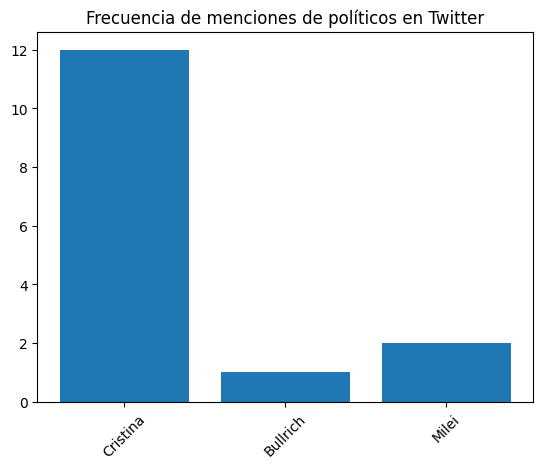

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

conteo = Counter(sum(df["menciones_politicos"], []))

plt.bar(conteo.keys(), conteo.values())
plt.xticks(rotation=45)
plt.title("Frecuencia de menciones de políticos en Twitter")
plt.show()